<a href="https://colab.research.google.com/github/AhirtonLopes/TDCSP2019_Demos/blob/master/Demo3_RNN_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo 3 - Gerador automatizado de textos no estilo de William Shakespeare

Neste notebook iremos treinar uma Rede Neural Recorrente (RNN) tendo em vista indexação e posterior construção automatizada de textos teatrais no estilo de escrita do escrito inglês William Shakespeare (1564 - 1616) usando Pytorch.

In [0]:
# Importando bibliotecas utilizadas

import tensorflow as tf
import numpy as np
import torch
import torch.cuda as cuda
import matplotlib.pyplot as plt


In [2]:
# Baixando nossa base de dados a ser utilizada na demo

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


1122304/1115394 [==============================] - 0s 0us/step


In [0]:
# Declarando nosso corpus textual a ser utilizado

corpus = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [4]:
print("Numero de palavras no corpus textual: ",len(corpus))
text=corpus.splitlines()
print("Numero de linhas no corpus textual ",len(text))

print("A primeira linha do corpus textual é => ",text[0])

# Criando nossos conjuntos de treino, teste e validação

for i in range(len(text)):
  text[i]=text[i]+" <end>" ## adicionando <end> ao final de cada linha 
print("Agora a primeira linha do corpus textual é => ",text[0]) 


words=' '.join(text)
words=words.split()
print("Mostrando as palavras de posição 0 a 100 em nosso corpus : ",words[0:100])

# Usamos essas palavras para criar vocabulário

Numero de palavras no corpus textual:  1115394
Numero de linhas no corpus textual  40000
A primeira linha do corpus textual é =>  First Citizen:
Agora a primeira linha do corpus textual é =>  First Citizen: <end>
Mostrando as palavras de posição 0 a 100 em nosso corpus :  ['First', 'Citizen:', '<end>', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', '<end>', '<end>', 'All:', '<end>', 'Speak,', 'speak.', '<end>', '<end>', 'First', 'Citizen:', '<end>', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish?', '<end>', '<end>', 'All:', '<end>', 'Resolved.', 'resolved.', '<end>', '<end>', 'First', 'Citizen:', '<end>', 'First,', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people.', '<end>', '<end>', 'All:', '<end>', 'We', "know't,", 'we', "know't.", '<end>', '<end>', 'First', 'Citizen:', '<end>', 'Let', 'us', 'kill', 'him,', 'and', "we'll", 'have', 'corn', 'at', 'our', 'own', 'price.', '<end>', "Is't", 'a', 'verdict?'

In [5]:
# Criando vocabulário

voc=[]

def return_index(word):
  return voc.index(word)
 
for word in words :
  if word not in voc:
    voc.append(word)
    
print("Indice da palavra (The) no vocabulario: ",return_index('The') )
print("A palavra para o indice de numero (203): ",voc[203] )

print("Comprimento de nosso vocabulario: ",len(voc))

Indice da palavra (The) no vocabulario:  203
A palavra para o indice de numero (203):  The
Comprimento de nosso vocabulario:  25671


In [6]:
# Convertendo palavras em índices e salvando em words_indexes

words_indexes=[return_index(word) for word in words]
print("Imprimindo alguns de nossos primeiros indices : ",words_indexes[0:100])

# Utilizamos words_indexes como entrada para nossa rede


Imprimindo alguns de nossos primeiros indices :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 2, 11, 2, 12, 10, 2, 2, 0, 1, 2, 13, 14, 15, 16, 17, 18, 19, 20, 18, 21, 2, 2, 11, 2, 22, 23, 2, 2, 0, 1, 2, 24, 25, 26, 27, 28, 29, 30, 31, 18, 32, 33, 2, 2, 11, 2, 34, 35, 4, 36, 2, 2, 0, 1, 2, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 2, 49, 50, 51, 2, 2, 11, 2, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 2, 2, 62]


In [7]:

seq_lenght=35 # comprimento de nossa RNN (comprimento do input)
batch_size=20
# quantos batches(com tamanho: [batch_size, seq_lenght])  temos para nosso array words_indexes ?
# resposta => len(words_indexes/(batch_size*seq_lenght))
max_batches=int(len(words_indexes)/(batch_size*seq_lenght))
print("O numero maximo de batches com essa configuracao e (batch_size,seq_lenght) :  ",max_batches)

trainsetX=words_indexes[0:int(0.9*max_batches)*batch_size*seq_lenght]
trainsetY=words_indexes[1:int(0.9*max_batches)*batch_size*seq_lenght+1]
validsetX=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght:int(1*max_batches)*batch_size*seq_lenght]
validsetY=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght + 1:int(1*max_batches)*batch_size*seq_lenght +1]

O numero maximo de batches com essa configuracao e (batch_size,seq_lenght) :   346


In [8]:
# Criando nossos batches

def create_batch(data,flag):
  if flag=='Train':
     return (np.array(data).reshape(int(0.9*max_batches) ,batch_size ,seq_lenght)) # shape (número do batch, batch_size,seq_enght)
  else :
     return (np.array(data).reshape(int(1*max_batches)-int(0.9*max_batches) ,batch_size ,seq_lenght)) # shape (número do batch, batch_size,seq_enght)
  
trainX_batches =create_batch(trainsetX,'Train')
trainY_batches =create_batch(trainsetY,'Train')

validX_batches =create_batch(validsetX,'Valid')
validY_batches =create_batch(validsetY,'Valid')


print("trainX_batches_shape: ",trainX_batches.shape)
print("trainY_batches_shape: ",trainY_batches.shape)

print("validX_batches_shape: ",validX_batches.shape)
print("validY_batches_shape: ",validY_batches.shape)

trainX_batches_shape:  (311, 20, 35)
trainY_batches_shape:  (311, 20, 35)
validX_batches_shape:  (35, 20, 35)
validY_batches_shape:  (35, 20, 35)


In [9]:
print(trainX_batches[0,0,:]) # batchNumber=0 , amostra de número 0 no batch , em todos os comprimentos de sequência
print(trainY_batches[0,0,:])
print(len(words_indexes))

[ 0  1  2  3  4  5  6  7  8  9 10  2  2 11  2 12 10  2  2  0  1  2 13 14
 15 16 17 18 19 20 18 21  2  2 11]
[ 1  2  3  4  5  6  7  8  9 10  2  2 11  2 12 10  2  2  0  1  2 13 14 15
 16 17 18 19 20 18 21  2  2 11  2]
242651


In [0]:
# Agregamos todas as informações em uma função

def get_batches():# uso no treinamento
  global  words_indexes
  a=[]
  b=[]
  
    # words_indexes shuffle
  a=words_indexes[0:int(0.2*len(words_indexes))]
  b=words_indexes[int(0.2*len(words_indexes)):]
  words_indexes=b+a

  trainsetX=words_indexes[0:int(0.9*max_batches)*batch_size*seq_lenght]
  trainsetY=words_indexes[1:int(0.9*max_batches)*batch_size*seq_lenght+1]
  validsetX=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght:int(1*max_batches)*batch_size*seq_lenght]
  validsetY=words_indexes[int(0.9*max_batches)*batch_size*seq_lenght + 1:int(1*max_batches)*batch_size*seq_lenght +1]

  trainX_batches =create_batch(trainsetX,'Train')
  trainY_batches =create_batch(trainsetY,'Train')
  validX_batches =create_batch(validsetX,'Valid')
  validY_batches =create_batch(validsetY,'Valid')
  
  return  trainX_batches,trainY_batches,validX_batches,validY_batches

In [0]:
# Criando nossa rede RNN

class net(torch.nn.Module):
  def  __init__(self,vocab_size,embed_size,hidden_size,number_of_layers,num_dir):
    super().__init__()
    
    # Se RNN for biderecional, num_directions será 2, senão 1
  
    self.num_directions=num_dir
    self.number_of_layers=number_of_layers
    self.hidden_size=hidden_size
    
    self.embd= torch.nn.Embedding(vocab_size, embed_size)
    self.drop1=torch.nn.Dropout(0.3)
    self.gru = torch.nn.GRU(embed_size, hidden_size, number_of_layers, dropout=0.4,bidirectional=False)
    self.drop2=torch.nn.Dropout(0.1)
    self.fc=torch.nn.Linear(hidden_size,vocab_size)
    self.init_weights()

  def forward(self,x,hidden):
    
    #x shape : torch.Size([seq_lenght, batch_size]) contem os índices de palavras de nosso vocabulário
    #hidden shape :torch.Size([num_layers * num_directions, batch_size, hidden_size])
    #média camada escondida h0
    
    emb=self.embd(x) 
    #emb shape : torch.Size([seq_lenght, batch_size, embed_size])
    out=self.drop1(emb)
    out , hidden =self.gru(emb,hidden) #  out = a camada escondidade mais alto nível para todos os steps |  hidden= contém valores para todas as camads escondidas do último timestep
    #out shape :  torch.Size([seq_lenght, batch_size, hidden_size  * num_directions])
    #hidden shape : torch.Size([num_layers * num_directions, batch_size, hidden_size])
    
    
    out=self.drop2(out) # it doesnt  change the dimension
   
    output=out.view(out.size(0)* out.size(1),out.size(2))   
    #out shape:  torch.Size([seq_lenght * batch_size, hidden_size  * num_directions])
    
    
    output=self.fc(output)
    #output shape:  torch.Size([seq_lenght * batch_size, vocab_size])
    
    
    output=output.view(out.shape[0], out.shape[1],output.shape[1])   
    #output shape:  torch.Size([seq_lenght , batch_size, vocab_size])

    
    # camada escondida é h0 no póximo processo de feed
    return output , hidden
  def init_weights(self):
        initrange = 0.1
        self.embd.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-initrange, initrange)
        
  def init_hidden(self, batch_size): # inicialização com zeros
        weight = next(self.parameters()).data
        return torch.autograd.Variable(weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_())
    

In [0]:
vocab_size=len(voc)
embed_size=250
hidden_size=200
number_of_layers=2
num_direction=1
learning_rate=0.001
clip = 0.25

In [13]:
model=net(vocab_size,embed_size,hidden_size,number_of_layers,num_direction)
print(model)
if cuda.is_available():
    model.cuda()

net(
  (embd): Embedding(25671, 250)
  (drop1): Dropout(p=0.3)
  (gru): GRU(250, 200, num_layers=2, dropout=0.4)
  (drop2): Dropout(p=0.1)
  (fc): Linear(in_features=200, out_features=25671, bias=True)
)


In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# calculating accuracy

def cal_accuracy(pred_classes,real_classes):#  shape -> both : [number of test samples,1]  ou both : [number of test samples,]
  bool_array=(pred_classes==real_classes) # exemplo: bool_array=[True, False, True, False, True]
  True_pred_counts=np.count_nonzero(bool_array) # contando o número de verdadeiros em [True, False, True, False, True]
  
  return True_pred_counts/pred_classes.shape[0]

In [0]:
#important notices:
#a.shape=(2,3,4)
#a.reshape(6,4) ->  (a000) (a001) (a002) (a003)      ,a021=a[0,2,1]
#                   (a010) (a011) (a012) (a013) 
#                   (a020) (a021) (a022) (a023) 
#                   (a100) (a101) (a102) (a103) 
#                   (a110) (a111) (a112) (a113) 
#                   (a120) (a121) (a122) (a123) 
#
#
#a.shape=(3,2,4)
#a.reshape(6,4) ->  (a000) (a001) (a002) (a003) 
#                   (a010) (a011) (a012) (a013) 
#                   (a100) (a101) (a102) (a103) 
#                   (a110) (a111) (a112) (a113) 
#                   (a200) (a201) (a202) (a203) 
#                   (a210) (a211) (a212) (a213) 
#
#
#a.shape=(3,2)
#a.reshape(6,1) ->  (a00) 
#                   (a01)  
#                   (a10)                   
#                   (a11)  
#                   (a20)  
#                   (a21) 
#
#
#a.shape=(2,3)
#a.reshape(6,1) ->  (a00) 
#                   (a01)  
#                   (a02)                   
#                   (a10)  
#                   (a11)  
#                   (a12) 
#
#
#
#
#
#

In [17]:
num_epochs=300
mean_train_acc=[]
mean_valid_acc=[]

for i in range(num_epochs):
  validacc=[]
  trainacc=[]
  hidden = model.init_hidden(batch_size)
  total_loss=0
  model.train()
  trainX_batches,trainY_batches,_,_=get_batches()
  for batchNumber in range(trainX_batches.shape[0]):
    
    X=torch.autograd.Variable(torch.LongTensor(trainX_batches[batchNumber].T)) 
    #train_batches[batchNumber].T  shape :nparray ([seq_lenght,batch_size]) 
    Y=torch.autograd.Variable(torch.LongTensor(trainY_batches[batchNumber].T.reshape(seq_lenght*batch_size)))  
    #Y:Torch.szie ([seq_lenght*batch_size]) => seq0batch0  ,  seq0batch1 ,  seq0batch2  , ..... 
    if cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
    
    hidden = torch.autograd.Variable(hidden)# separando o estado escondido de uma iteração para outra
    # essa em específico será usada para o plot de nosso gráfico computacional
   
    if cuda.is_available():
             hidden = hidden.cuda()
    
    optimizer.zero_grad()
    outputs,hidden=model(X,hidden)# outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(seq_lenght*batch_size, vocab_size)
    #outputs shape:  torch.Size([seq_lenght * batch_size, vocab_size])=> seq0batch0,vocab  ,  seq0batch1,vocab ,  seq0batch2,vocab  , .....
    
    loss=criterion(outputs,Y)
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), clip)
    optimizer.step()

    pred=outputs
    pred_classes=torch.max(pred, 1)[1]# pred_classes.shape : torch.Size([seq_lenght * batch_size])
    acc=cal_accuracy(np.array(pred_classes.cpu()),Y.cpu().numpy()) 
    trainacc.append(acc*100)

  print("Acuracia de treinamento na epoca: ",i," e ",np.mean(trainacc))
  mean_train_acc.append(np.mean(trainacc))
  hidden = model.init_hidden(batch_size)
  model.eval() 
  _,_,validX_batches,validY_batches=get_batches()

  for batchNumber in range(validX_batches.shape[0]):
    
    X=torch.autograd.Variable(torch.LongTensor(validX_batches[batchNumber].T)) 
    #valid_batches[batchNumber].T  shape :nparray ([seq_lenght,batch_size]) 
    Y=torch.autograd.Variable(torch.LongTensor(validY_batches[batchNumber].T.reshape(seq_lenght*batch_size)))  
    #Y:Torch.szie ([seq_lenght*batch_size]) 
    if cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
  
    if cuda.is_available():
            hidden = hidden.cuda()
      
    outputs,hidden=model(X,hidden)
    # outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(seq_lenght*batch_size, vocab_size)
    # outputs shape:  torch.Size([seq_lenght * batch_size, vocab_size])
    pred=outputs 
    pred_classes=torch.max(pred.data, 1)[1]# torch.Size([seq_lenght * batch_size])
    acc=cal_accuracy(np.array(pred_classes.cpu()),Y.cpu().numpy())
    validacc.append(acc*100)

  print("Acuracia de validacao na epoca: ",i," e ",np.mean(validacc))
  mean_valid_acc.append(np.mean(validacc))

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Acuracia de treinamento na epoca:  0  e  16.905374368396878
Acuracia de validacao na epoca:  0  e  16.436734693877554
Acuracia de treinamento na epoca:  1  e  19.45705098759761
Acuracia de validacao na epoca:  1  e  19.22448979591837
Acuracia de treinamento na epoca:  2  e  20.864033073036286
Acuracia de validacao na epoca:  2  e  21.22448979591837
Acuracia de treinamento na epoca:  3  e  22.345888837850254
Acuracia de validacao na epoca:  3  e  22.281632653061227
Acuracia de treinamento na epoca:  4  e  23.278824069820857
Acuracia de validacao na epoca:  4  e  24.00816326530612
Acuracia de treinamento na epoca:  5  e  23.883785025264125
Acuracia de validacao na epoca:  5  e  23.004081632653065
Acuracia de treinamento na epoca:  6  e  24.418925126320627
Acuracia de validacao na epoca:  6  e  22.9265306122449
Acuracia de treinamento na epoca:  7  e  24.927882406982082
Acuracia de validacao na epoca:  7  e  24.448979591836732
Acuracia de treinamento na epoca:  8  e  25.615066605420303
Ac

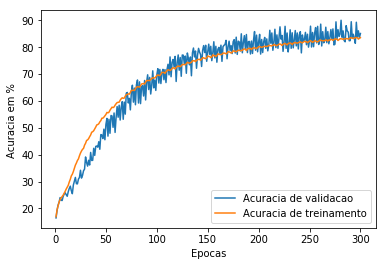

In [18]:
plt.plot([i+1 for i in range(num_epochs)],mean_valid_acc,label="Acuracia de validacao")
plt.plot([i+1 for i in range(num_epochs)],mean_train_acc,label="Acuracia de treinamento")
plt.legend(loc='best')
plt.xlabel("Epocas")
plt.ylabel("Acuracia em % ")
plt.show()

In [19]:
# Gerando palavras

print("GERANDO TEXTO FALSO DE WILLIAM SHAKESPEARE: \n________________________________________________________")
num_words=2000 # número de palavras que gostaríamos de gerar
testacc=[]

# Qual a primeira palavra palavra do texto (cold start)? Nesse caso será (The)

input_word_index=return_index('The')
print('The',end=" ")
X=torch.autograd.Variable(torch.LongTensor(np.array([input_word_index]).reshape(1,1)))
hidden = model.init_hidden(1)

for i in range(num_words):

    if cuda.is_available():
            X = X.cuda()
           
  
  
#     print(hidden.shape)
    outputs,hidden=model(X,hidden)# outputs shape:  torch.Size([seq_lenght , batch_size, vocab_size])
    outputs=outputs.view(vocab_size)
    outExp=outputs.exp()
#     print(outputs)
    probablistic_output=(outExp)/(outExp.sum())# probablistic_output shape: torch.Size([vocab_size])
#     probablistic_output=((outputs)/(0.4)).exp()

    word_index = (torch.multinomial(probablistic_output, 1))
    X=torch.autograd.Variable((word_index).reshape(1,1))
    if(voc[word_index]=="<end>"):
      print("")
    else:
      print(voc[word_index],end=" ")

GERANDO TEXTO FALSO DE WILLIAM SHAKESPEARE: 
________________________________________________________
The alliance to thy brother Valentine; mine 
uncle Capulet, his wife and daughters; my fair niece 
Rosaline; Livia; Signior Valentio and his cousin 
Tybalt, Lucio and the lively Helena.' A fair 
assembly: whither should they come? 

Servant: 
Up. 

ROMEO: 
Whither? 

Servant: 
To supper; to our house. 

ROMEO: 
Whose house? 

Servant: 
My master's. 

ROMEO: 
Indeed, I should have ask'd you that before. 

Servant: 
Now I will tell thee, sir. 

ROMEO: 
In saying so, 
Her chariot is an empty hazel-nut 
Made by the joiner squirrel or old grub, 
Time out o' mind the fairies' coachmakers. 
And in this state she gallops night by night 
Through lovers' brains, and then they dream of love; 
O'er courtiers' knees, that dream on court'sies straight, 
O'er lawyers' fingers, who straight dream on fees, 
O'er ladies ' lips, who straight on kisses dream, 
Which oft the angry Mab with blisters plagues